### Strategy 1

Preprocessing step done by running: `python chmt_preproc/main.py --data-path proj_data/ --out-path preproc_data/`

Generates csv file for each subject, Additionaly we get path_file.csv that contains a summary with information to access each subject dataset.

In [96]:
import numpy as np
import pandas as pd
from scipy.signal import welch

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

read summary of dataset

In [81]:
path_file = pd.read_csv('preproc_data/path_file.csv')

In [82]:
# first strategy
def get_extracts(file_names, targets, sfreqs):
    """
    Args:
    file_names = [fn1.csv, fn2.csv, ...]
    targets = ['trauma', 'healthy', ...]
    sfreqs = [freq1, freq2, ...]
    
    #records = [np.array[n_samples, n_channels], np.array, np.array, ..]
    
    Return:
    records = []
    """
    records = []
    targets_chunk = []
    for fn, target, sfreq in zip(file_names, targets, sfreqs):
        record = pd.read_csv(f'preproc_data/{fn}')
        if len(record) < 60 * sfreq:
            continue
        records.append(record[:60*sfreq])
        targets_chunk.append(target)
        
    return records, targets_chunk


In [83]:
fns = path_file['fn']
targets = path_file['target']
sfreqs = path_file['sfreq']

In [84]:
records, targets = get_extracts(fns, targets, sfreqs)

In [90]:
len(records), len(targets)

(185, 185)

For strategy one we get 185 subjects to analyze

#### Features construction

First let's see the raw signals from different channels for some random subjects

In [99]:
records[20].head()

,time,fp1,fp2,f7,f3,fz,f4,f8,t3,c3,cz,c4,t4,t5,p3,pz,p4,t6,o1,o2
0,0,2.242732,5.419165,1.928916,-2.329892,-5.784086,-4.523097,2.420615,3.961377,1.124861,0.0,-1.279839,4.562347,7.971806,8.407634,8.355937,5.151509,6.662781,9.864745,8.807678
1,8,6.870101,1.476426,1.399882,-0.710076,0.476928,-3.865594,3.733017,1.193905,-0.686372,0.0,4.352129,8.677736,2.774224,3.078873,8.960938,6.507118,9.273965,7.271033,3.774219
2,16,13.003960,1.359983,4.146531,4.694282,9.985937,2.019993,8.721019,1.961267,0.151444,0.0,12.708134,16.739708,1.012643,-2.188651,7.623592,9.942066,14.365974,4.401106,0.169254
3,24,16.319438,3.272260,7.953360,10.928953,15.860221,7.150622,11.651665,5.127535,3.204786,0.0,18.254341,22.268371,3.457988,-5.265813,2.619115,13.130582,18.274944,2.695271,-0.191299
4,32,14.290007,1.028703,8.430594,13.632203,15.367846,5.281752,6.641774,6.587033,5.106537,0.0,18.092643,19.835607,4.629078,-7.015975,-4.203143,13.742218,18.644036,2.107993,0.978300


In [107]:
def plot_rawsignal(time, signal, channel):
    # fig= plt.figure(figsize=(15,4))
    # plt.plot(records[20]['time'], records[20]['t4'])

    # Plot the signal
    fig= plt.figure(figsize=(15,4))
    plt.plot(time, signal, lw=1.5, color='k')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Voltage')
    plt.xlim([time.min(), time.max()])
    plt.title(f'Brain activity, EEG data ({channel})')
    sns.despine()

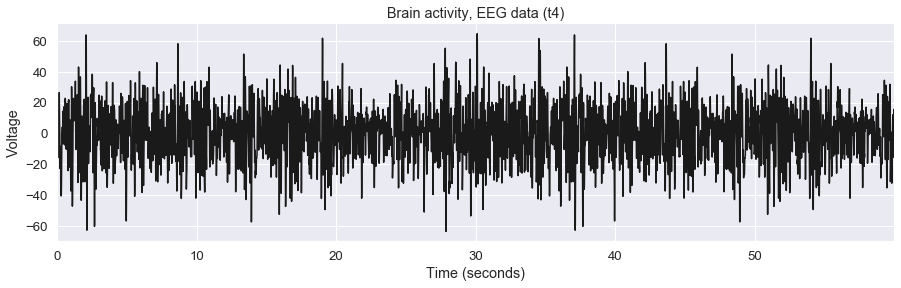

In [106]:
# subject
subject = 20
channel = 't4'
signal = records[subject][channel]

# Define sampling frequency and time vector
sf = 125.
time = np.arange(records[subject].shape[0]) / sf

plot_rawsignal(time, signal, channel)

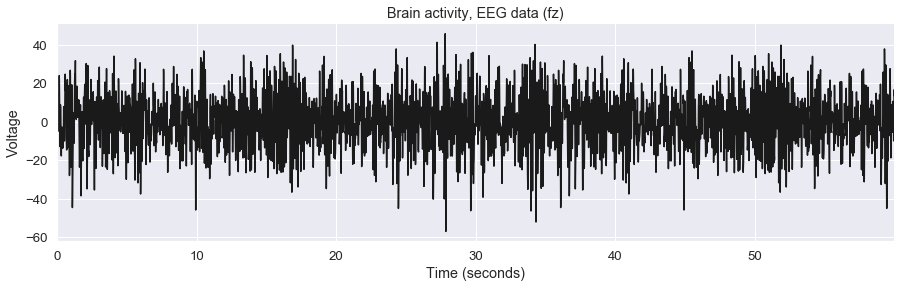

In [109]:
channel = 'fz'
signal = records[subject][channel]
plot_rawsignal(time, signal, channel)

As we can see from the plots above, we can't say something meaningful about the signal.

Let's see more meaningful pictures.

In [115]:
targets[20]

'trauma'

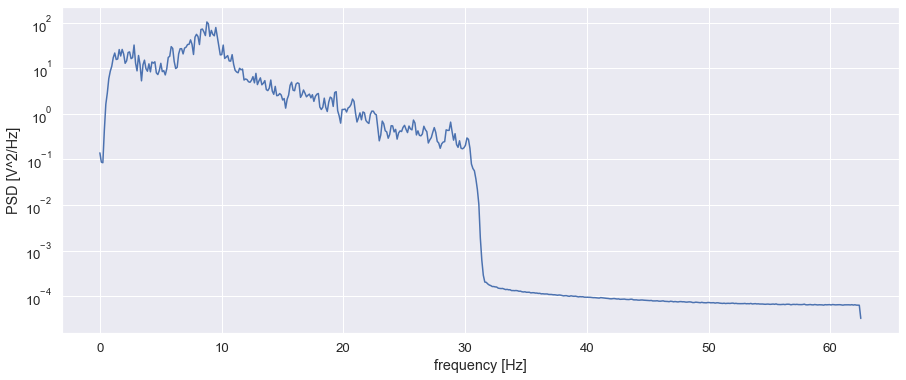

In [113]:
freqs, psd = welch(records[subject]['t4'], fs=125, nperseg=1024)

fig = plt.figure(figsize=[15,6])
plt.semilogy(freqs, psd)
#plt.ylim([0, psd.max()])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.show()

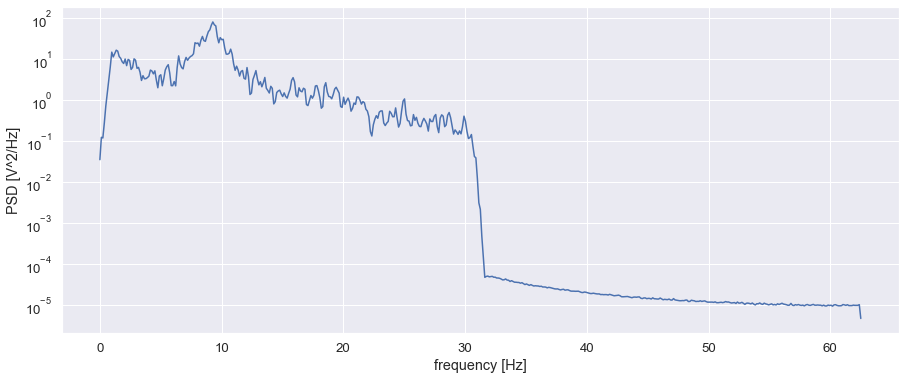

In [112]:
freqs, psd = welch(records[subject]['fz'], fs=125, nperseg=1024)

fig = plt.figure(figsize=[15,6])
plt.semilogy(freqs, psd)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.show()

Now let's check for a random healthy subject

In [119]:
subject=150
targets[150]

'healthy'

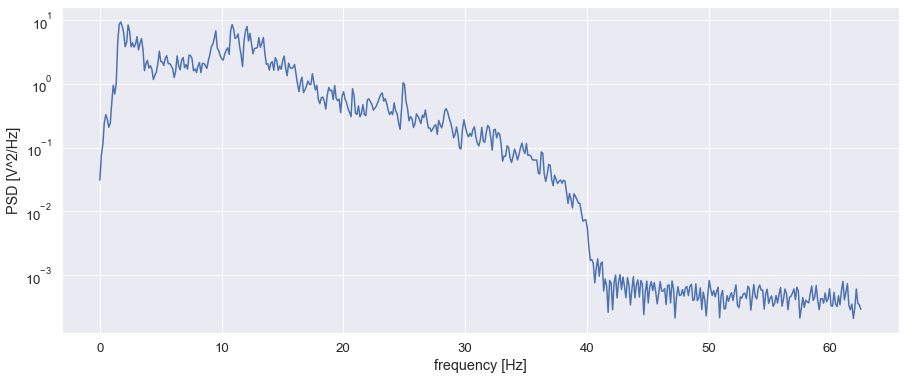

In [122]:
freqs, psd = welch(records[subject]['t4'], fs=125, nperseg=1024)

fig = plt.figure(figsize=[15,6])
plt.semilogy(freqs, psd)
#plt.ylim([0, psd.max()])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.show()

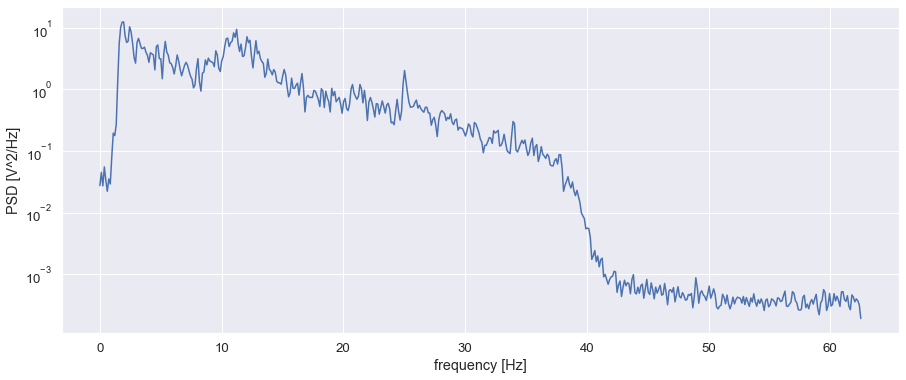

In [121]:
freqs, psd = welch(records[subject]['fz'], fs=125, nperseg=1024)

fig = plt.figure(figsize=[15,6])
plt.semilogy(freqs, psd)
#plt.ylim([0, psd.max()])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.show()

There seems to be a difference on the PSD on the raw signal for a subject with trauma and a healthy one. In the first case there is huge drop on the psd value for frequencies higher than 30 Hz. In the latter case, however, the drop of psd is smooth and happens for frequencies above 40 Hz.

This difference would suggest the filtering of the signal (for now I would say > 30Hz and < 1Hz)

**Band pass filtering**

can be done with filter function from mne

**Average Band Power**

Next we will try to find a number representing the power contribution of a particular band to the overall power of the signal.

We'll start from this 'prior' as mentioned here (https://www.frontiersin.org/articles/10.3389/fnhum.2015.00011/full)
> mTBI injury is often associated with a decrease in alpha power and an __increase in delta__, beta, and theta bands.


Let's analyze delta band

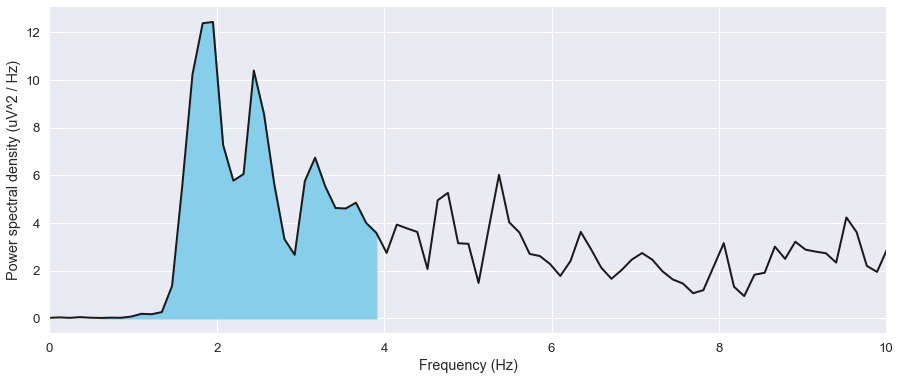

In [131]:
# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=[15, 6])
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
#plt.ylim([0, psd.max() * 1.1])
sns.despine()

In [132]:
from scipy.integrate import simps

# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

Absolute delta power: 15.933 uV^2


In [133]:
# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f' % delta_rel_power)

Relative delta power: 0.250


This means that just 25% of the total power is contained in the beta band

**Ratio**

In [134]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [135]:
# Define the duration of the window to be 4 seconds
win_sec = 4
data = records[subject]['fz']

# Delta/beta ratio based on the absolute power
db = bandpower(data, sf, [0.5, 4], win_sec) / bandpower(data, sf, [12, 30], win_sec)

# Delta/beta ratio based on the relative power
db_rel = bandpower(data, sf, [0.5, 4], win_sec, True) / bandpower(data, sf, [12, 30], win_sec, True)

print('Delta/beta ratio (absolute): %.3f' % db)
print('Delta/beta ratio (relative): %.3f' % db_rel)

Delta/beta ratio (absolute): 0.844
Delta/beta ratio (relative): 0.844
